# NOTEBOOK 3e: MODELING - KNNeighbors

The KNearestNeighbors algorithm models each datapoint in space and makes predictions based off the nearest known values. This may be a good predictor on our dataset since it is relatively dense and is predicting on relatively few features.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pickle
import re
import time

from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, SelectFromModel, f_regression, RFECV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

np.random.seed(42)

%matplotlib inline

Loading the clean training data from Notebook 02

In [7]:
df = pd.read_csv('../data/train_clean.csv', index_col='Id', na_filter=False)

In [8]:
df.head()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Bsmt Unf SF,Total Bsmt SF,Central Air,...,Misc Feature_none,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
Id,,,,,,,,,,,,,,,,,,,,,
109,0.0,13517,6,8,1976,2005,289.0,192.0,725.0,1,...,1,0,0,0,0,0,0,0,0,1
544,43.0,11492,7,5,1996,1997,132.0,276.0,913.0,1,...,1,0,0,0,0,0,0,0,0,1
153,68.0,7922,5,7,1953,2007,0.0,326.0,1057.0,1,...,1,0,0,0,0,0,0,0,0,1
318,73.0,9802,5,5,2006,2007,0.0,384.0,384.0,1,...,1,0,0,0,0,0,0,0,0,1
255,82.0,14235,6,8,1900,1993,0.0,676.0,676.0,1,...,1,0,0,0,0,0,0,0,0,1


In [9]:
X = df.drop(['SalePrice'],axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
model = 'knn'

In [68]:
pipe = Pipeline([
    ('var_thresh', VarianceThreshold(0)),
    ('ss', StandardScaler()),
    ('kbest', SelectKBest(f_regression, k=37)),
#    ('enet', ElasticNetCV()),
#     ('lasso', LassoCV()),
#     ('ridge', RidgeCV()),
    ('knn', KNeighborsRegressor(weights='uniform')),
])


In [69]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=37, score_func=<function f_regression at 0x1a1ab7e620>)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))])

In [70]:
pipe.score(X_train,y_train)

0.8828669713118971

In [71]:
pipe.score(X_test,y_test)

0.8642404497217813

In [72]:
params = {
    'var_thresh__threshold': [0,.001,.01,.02,.05],
    'kbest__k': [5,7,13,17,23,37,53,79,'all'],
    'knn__n_neighbors':[3,5,7,9],
}

We will search over 10000 alphas to optimize our mode fit.

In [73]:
gs = GridSearchCV(pipe, params, cv=5, scoring='r2', verbose=1)

In [74]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  2.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=37, score_func=<function f_regression at 0x1a1ab7e620>)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'var_thresh__threshold': [0, 0.001, 0.01, 0.02, 0.05], 'kbest__k': [5, 7, 13, 17, 23, 37, 53, 79, 'all'], 'knn__n_neighbors': [3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

In [75]:
gs.best_params_

{'kbest__k': 7, 'knn__n_neighbors': 7, 'var_thresh__threshold': 0}

In [76]:
gs.best_estimator_.named_steps['knn']

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=7, p=2,
          weights='uniform')

The model performed best with 7 neighbors

In [77]:
gs.score(X_train,y_train)

0.8858555696913936

In [78]:
gs.score(X_test,y_test)

0.8800297295301404

The 'distance' train/test scores (99.95/97.36) show a highly overfit model with high variance and low bias. The 'uniform' model was much more consistent as seen above.

In [79]:
preds = gs.predict(X_test)

In [80]:
r2_score(preds, y_test)

0.8666350864336019

In [81]:
(mean_squared_error(preds, y_test))**.5

28744.109497409503

The r2 and rmse (84.77/29496.96) also suggest a much worse fit than lasso. This model either needs further optimization or simply is not the correct way to approach our data, possibly due to a relatively small dataset. Again, much better than 'distance' but still not our top performing model.

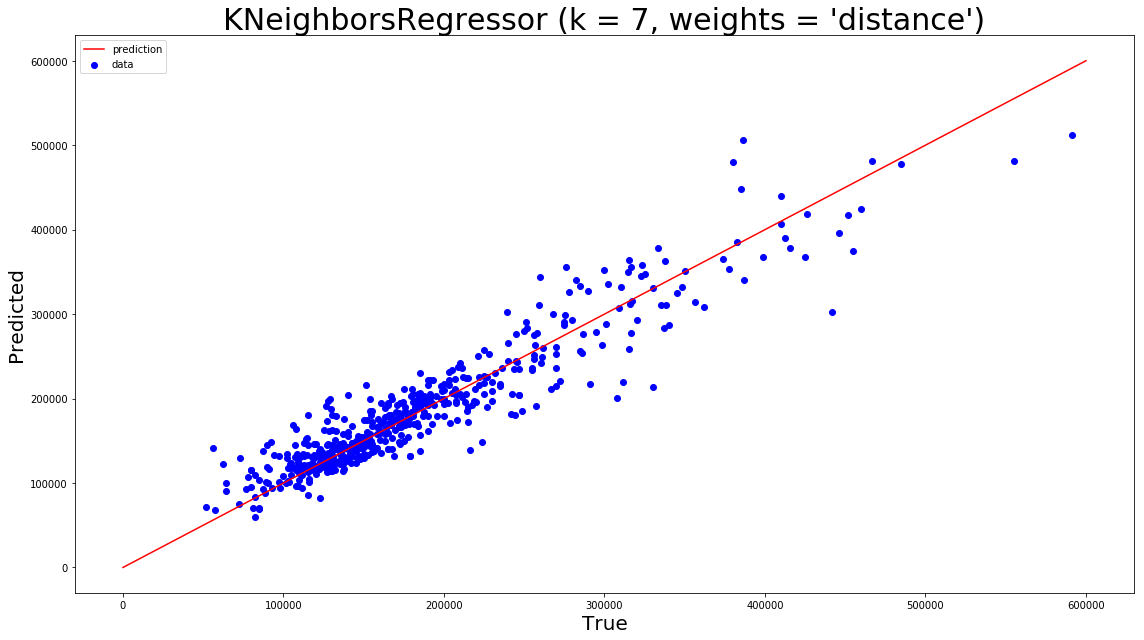

<Figure size 432x288 with 0 Axes>

In [82]:
plt.figure(figsize=(16,9))
plt.title(f'Predicted vs. True: \n KNeighborsRegressor (k = 7, weights = distance), RMSE:{mean_squared_error(y_test, gs.predict(X_test))**.5:.2f}', 
          fontsize=30);

plt.scatter(y_test, preds, c='b', label='data')
plt.plot([0,600000], [0,600000], c='r', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = 7, weights = 'distance')", fontsize=30)

plt.ylabel('Predicted', fontsize=20)
plt.xlabel('True', fontsize=20)

plt.tight_layout()
plt.show()


 
    
plt.savefig('../images/knn_7u.png', dpi=300)

This model performs better than our previous models across all values. Most importantly, it more closely predicts the values of the outliers at \$550000-600000.

In [52]:
X_test.shape

(512, 254)

# Saving out column names and scaled data for use in future models.

Function to save out files with a clear description of each run. Source: Douglas Strodman.

In [83]:
def filename_format_log(file_path, #path for saving out file of interest
                        logfile='../assets/file_log.txt', #default value
                        now=round(time.time()), #time in epoch time
                        file_description=None): 
    try:
        ext = re.search('(?<!^)(?<!\.)\.(?!\.)', file_path).start() #regx arg to search string for patterns 
                                                                    #(period not followed or preceeded by a period or follows string)
    except:
        raise NameError('Please enter a relative path with a file extension.') 
    formatted_name = f'{file_path[:ext]}_{now}{file_path[ext:]}' #capture everything to (.) and then add (_) time
    if not file_description:
        file_description = input('Please provide a brief description: ')
    with open(logfile, 'a+') as f:
        f.write(f'{formatted_name}: {file_description}\n')
    return formatted_name, now, file_description

Saving columns that were retained by the model

In [84]:
columns = X_train.columns

In [85]:
formatted_name, now, file_description= filename_format_log('../assets/columns.pkl')

with open(formatted_name, 'wb+') as f:
    pickle.dump(columns, f)

Please provide a brief description:  knn=7u


In [86]:
formatted_name, _, _= filename_format_log('../assets/gs.pkl', now=now, file_description=file_description)

with open(formatted_name, 'wb+') as f:
    pickle.dump(gs, f)